In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import pymc as pm
import arviz as az
from scipy import stats

from src.utils import basic as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Linear Regression

* Geocentric
* Gaussian
    * Generative: Summed fluctuations tend toward Normal distribution
    * Inferential: For estimating mean and variance, the Normal distribution is least informative (fewest assumptions), in the maximum entropy sense

### Generative Normal distribution from summation of decisions

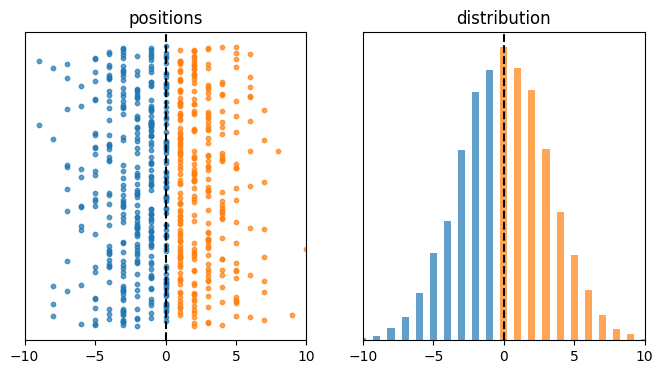

In [2]:
n_people = 10_000
n_steps = 1_000

step_size = .1
steps = step_size * (2 * stats.bernoulli(p=.5).rvs(size=(n_people, n_steps)) - 1)

positions = np.round(np.sum(steps, axis=1))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
plt.axvline(0, color='k', linestyle='--')
for idx, pos in enumerate(positions[::15]):
    color = 'C1' if pos > 0 else 'C0'
    plt.scatter(x=pos, y=idx, color=color, alpha=.7, s=10)
    
plt.xlim([-10, 10])
plt.yticks([])
plt.title("positions")

# plot histogram of positions
position_unique, position_counts = np.unique(positions, return_counts=True)
positive_idx = position_unique >= 0
negative_idx = position_unique < 0
plt.sca(axs[1])
plt.bar(position_unique[positive_idx], position_counts[positive_idx], width=.5, color='C1', alpha=.7)
plt.bar(position_unique[negative_idx], position_counts[negative_idx], width=.5, color='C0', alpha=.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlim([-10, 10])
plt.yticks([])
plt.title("distribution");


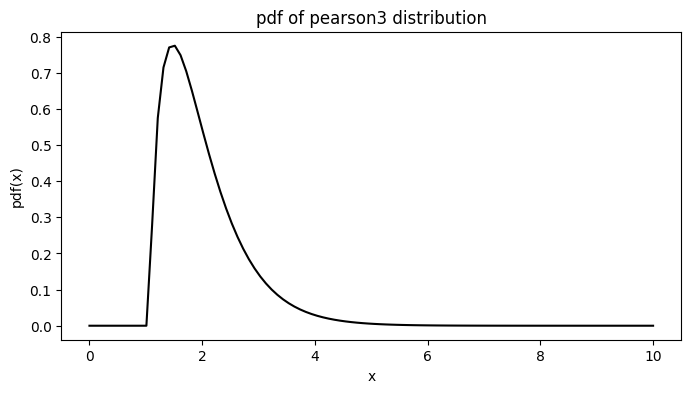

In [11]:
# Plot following distribution pdf: stats.pearson3.rvs(skew=1.5, loc=2, scale=1)

plt.figure(figsize=(8, 4))
x = np.linspace(0, 10, 100)
plt.plot(x, stats.pearson3.pdf(x, skew=1.5, loc=2, scale=.7), color='k')
plt.title("pdf of pearson3 distribution")
plt.xlabel("x")
plt.ylabel("pdf(x)");



